# Creation of the subbasins of Bow River at Calgary
## The rivers and subbasins include the network topolgy infromation such as which segmenets drains into which river segmenets

In [2]:
# loading candex
from candex.candex import candex
# initializing candex object
cndx = candex()
cndx.case_namendex            = 'Bow_at_Calgary'
cndx.temp_dir                 = '../temporary/'
cndx.output_dir               = '../output/'

easymore detect the tif file is projected in WGS84
direction map is not provided; candex will calculate flow direction and save in temporary file:
candex will save the direction file here:  ../temporary/case_temp_dir.tif
candex will save the accumulation file here:  ../temporary/case_temp_acc.tif


/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76


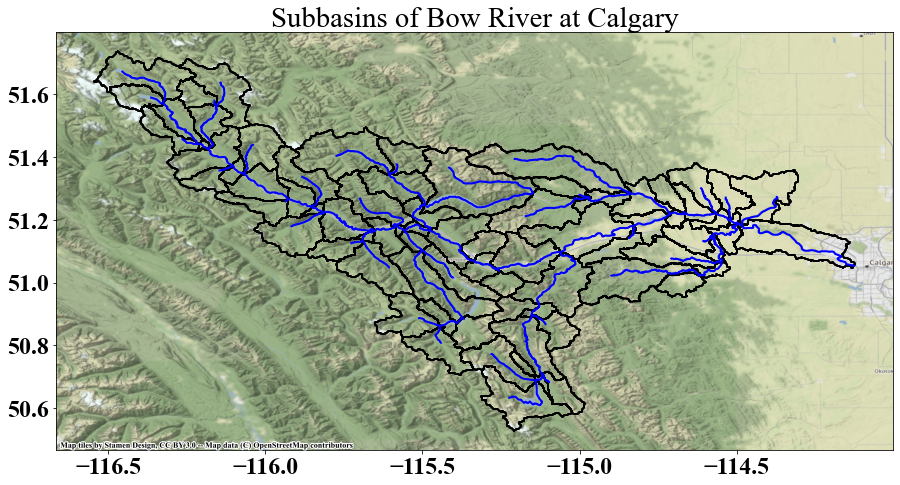

In [6]:
cndx.run_subbasin_creation(  '../data/MERIT_HYDRO/MERIT_dem.tif',
                              pour_point = (-114.127,51.054), # city of clagary
                              river_thr = 10000) #starting point of river in number of cells
# visualzing the results:
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import contextily as ctx
font = {'family' : 'Times New Roman',
         'weight' : 'bold',
         'size'   : 24}
matplotlib.rc('font', **font)
cat = gpd.read_file(cndx.output_dir+cndx.case_name+'_subbasin.shp')
riv = gpd.read_file(cndx.output_dir+cndx.case_name+'_river_NTOPO.shp')
# plotting
f, axes = plt.subplots(1,1,figsize=(15,15))
cat.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 2, ax = axes)
riv.geometry.plot(color='blue',linewidth = 2, ax = axes)
ctx.add_basemap(axes, zoom=10, crs='EPSG:4326')
plt.title ('Subbasins of Bow River at Calgary')
# plt.savefig('../fig/Example10_A.png')
plt.show()

# Zonal statistics for raster with discrete values such as land cover codes in subbasin of South Saskatchewan River; histogram is set to True to have the mode of land cover type

/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:>

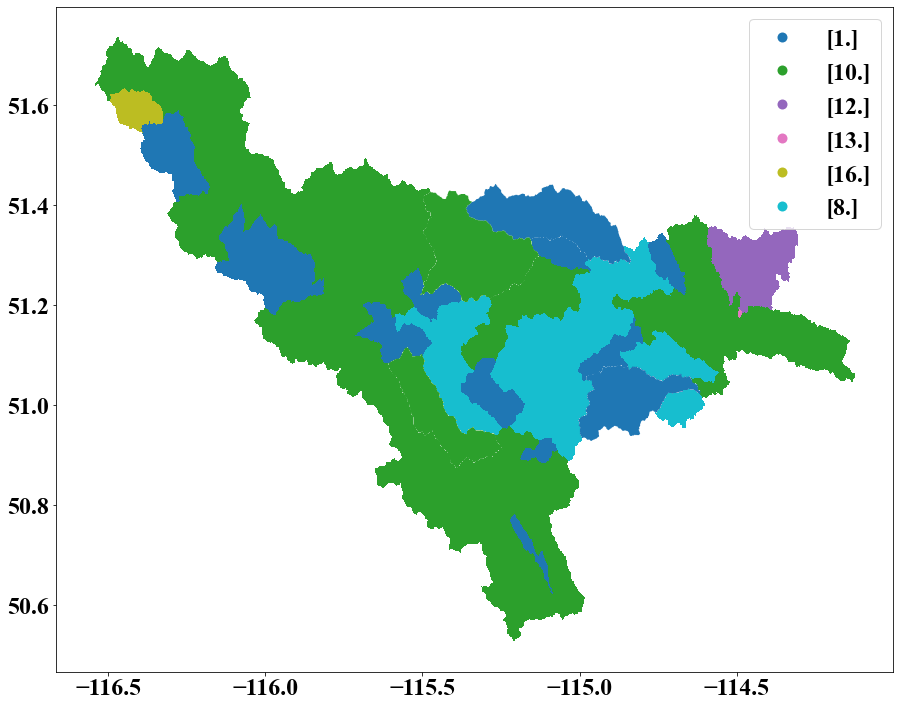

In [7]:
shp = cndx.zonal_stat(cndx.output_dir+cndx.case_name+'_subbasin.shp',
                      '../data/land_cover/land_use.tif',
                      histogram = True)
shp.to_file(cndx.output_dir+cndx.case_name+'_subbasin_land_cover.shp')
# visualize
# plotting
f, axes = plt.subplots(1,1,figsize=(15,15))
shp.plot(column = 'mode', ax = axes, legend = True)

------------
------------
# Zonal statistic of two vectors; subbasins of South Saskatchewan River and shapefiles constructed based on raster of land cover

/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/candex/candex.py:1259: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  pairs = gpd.GeoDataFrame(nei, columns=['idx1','idx2'], crs=df1.crs)
/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/candex/candex.py:1263: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  pairs = gpd.GeoDataFrame(pairs, columns=pairs.columns, crs=df1.crs)


Text(0.5, 1.0, 'Percent of cominant land cover in each subbasins')

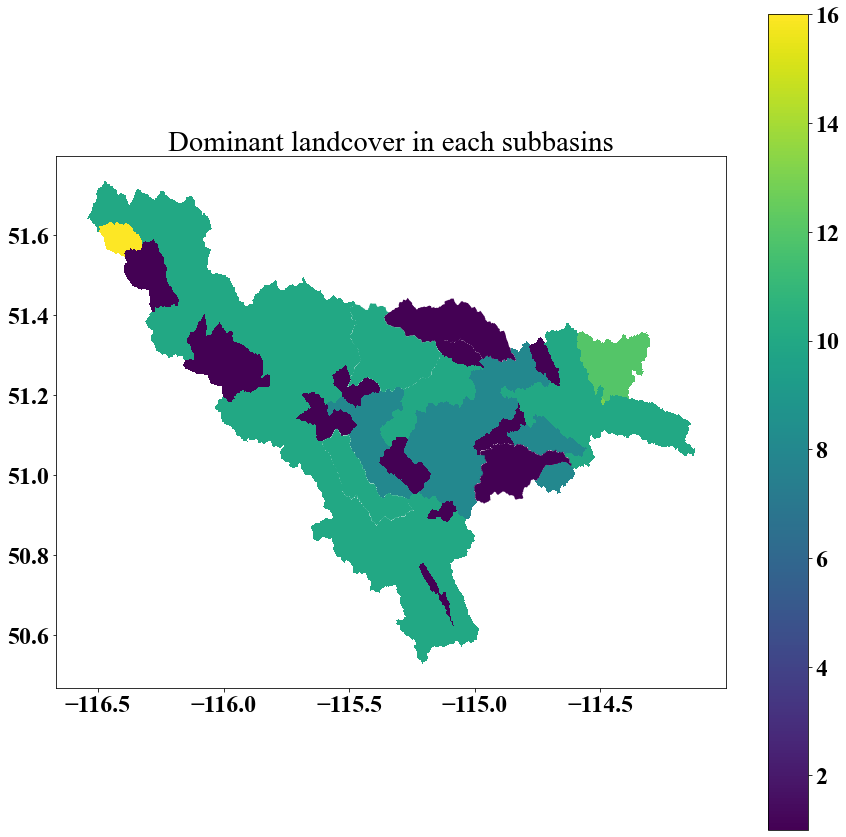

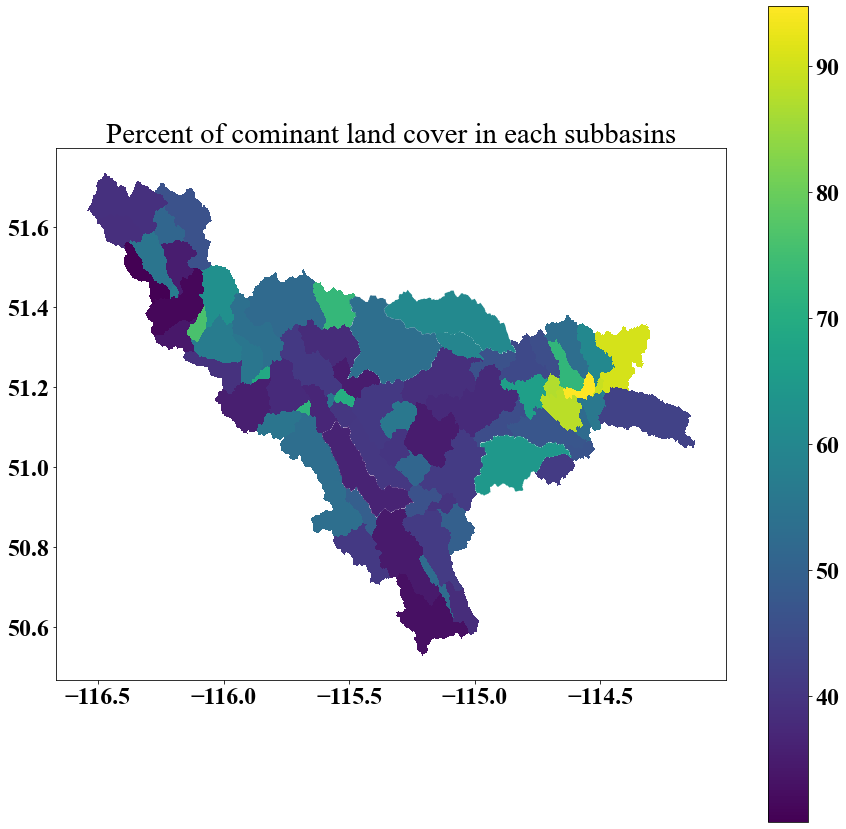

In [8]:
# convert land cover from geotiff to shapefile
cndx.geotif2shp( '../data/land_cover/land_use.tif',
                 '../temporary/land_use.shp',
                 name_of_filed = 'land_cover')

# calling the zonal_stat_vector for finding the values of second shapefile in the first shapefile
shp_int = cndx.zonal_stat_vector(cndx.output_dir+cndx.case_name+'_subbasin.shp',
                                 '../temporary/land_use.shp',
                                 field_ID_1 = 'ID',
                                 field_ID_2 = 'land_cover')


# get the maximume percent for a given subbasin
idx = shp_int.groupby(['ID_1'])['percent'].transform(max) == shp_int['percent']
shp_max = shp_int[idx]
shp_max = shp_max.sort_values(by='ID_1')
shp_max = shp_max.reset_index(drop=True)
shp_target = gpd.read_file(cndx.output_dir+cndx.case_name+'_subbasin.shp')
shp_target = shp_target.sort_values(by='ID')
shp_target = shp_target.reset_index(drop=True)
shp_target['land_cover'] = shp_max ['land_cover_2']
shp_target['percent'] = shp_max ['percent']
#
f, axes = plt.subplots(1,1,figsize=(15,15))
shp_target.plot(column  = 'land_cover', legend=True, ax = axes)
plt.title ('Dominant landcover in each subbasins')
#
f, axes = plt.subplots(1,1,figsize=(15,15))
shp_target.plot(column  = 'percent', legend=True, ax = axes)
plt.title ('Percent of cominant land cover in each subbasins')



---------
---------
# Zonal statistics for raster with continouse values such as dem (digital elevation model); histogram is set to Flase (as default)

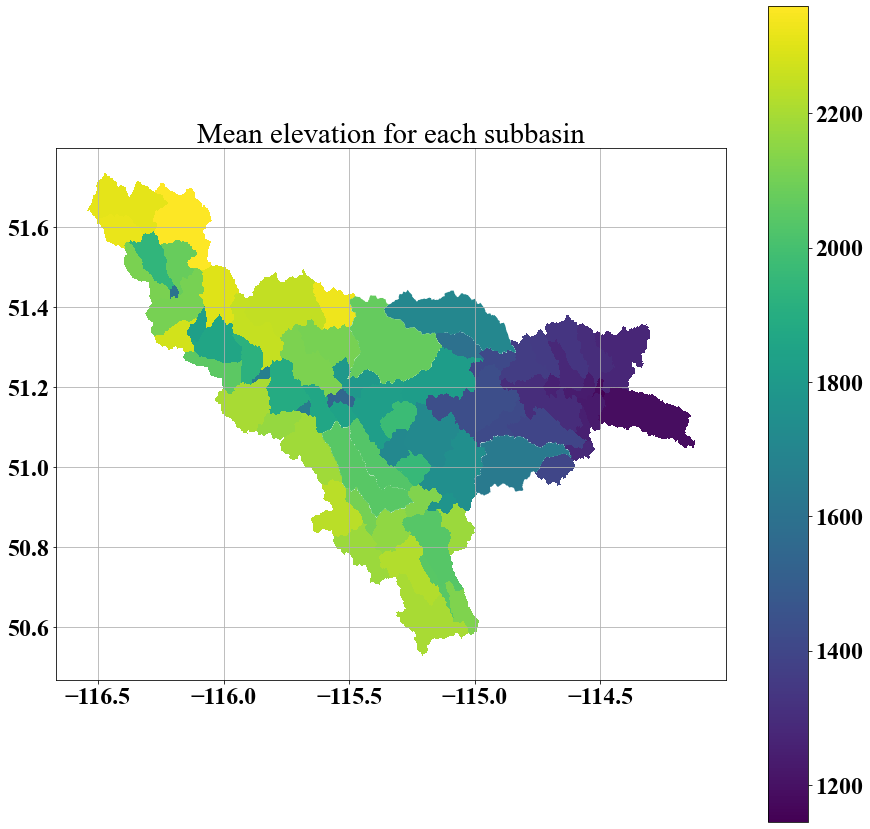

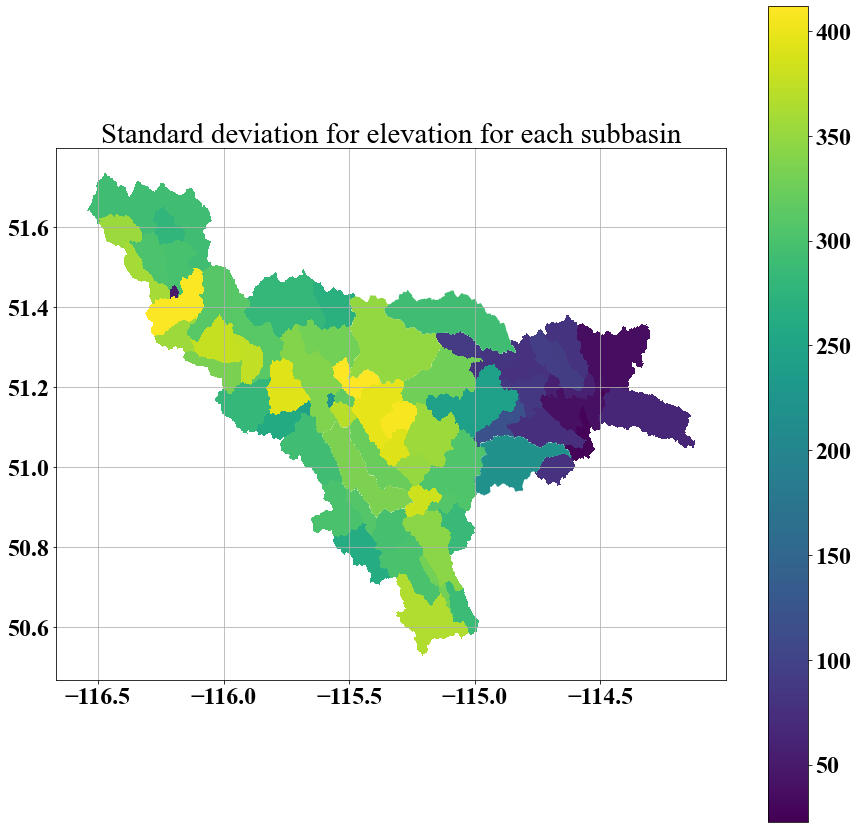

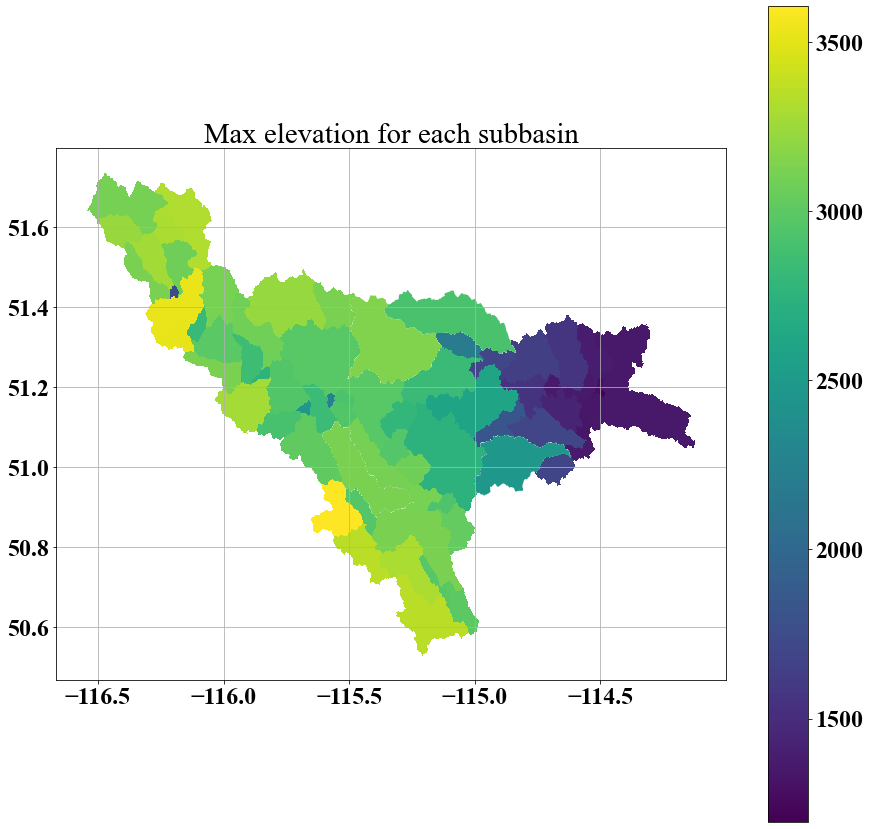

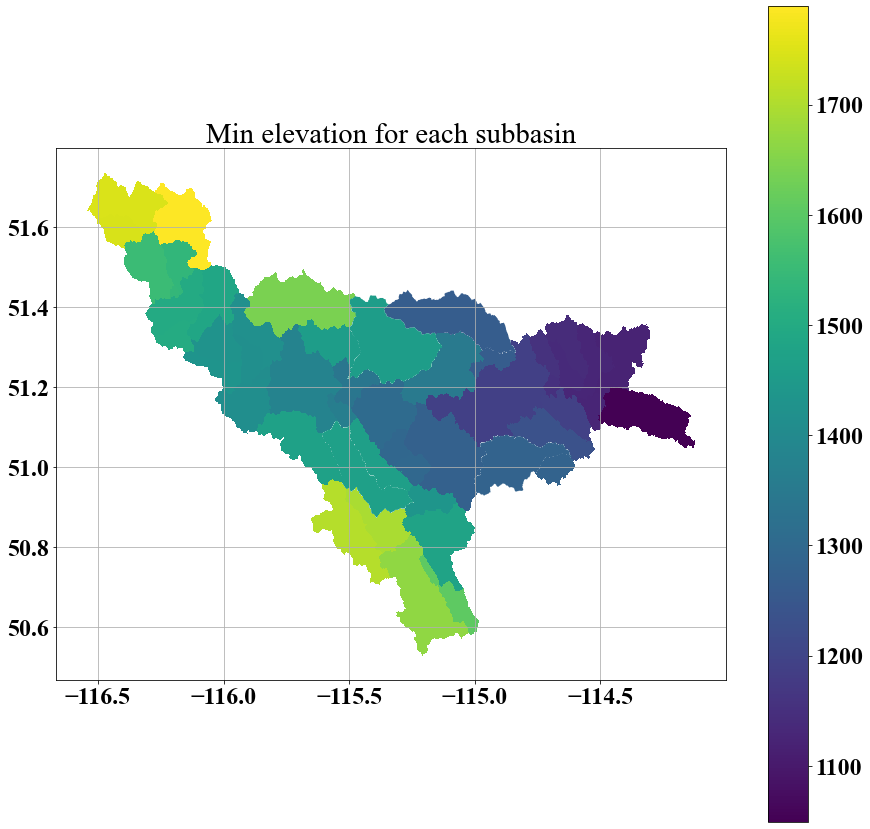

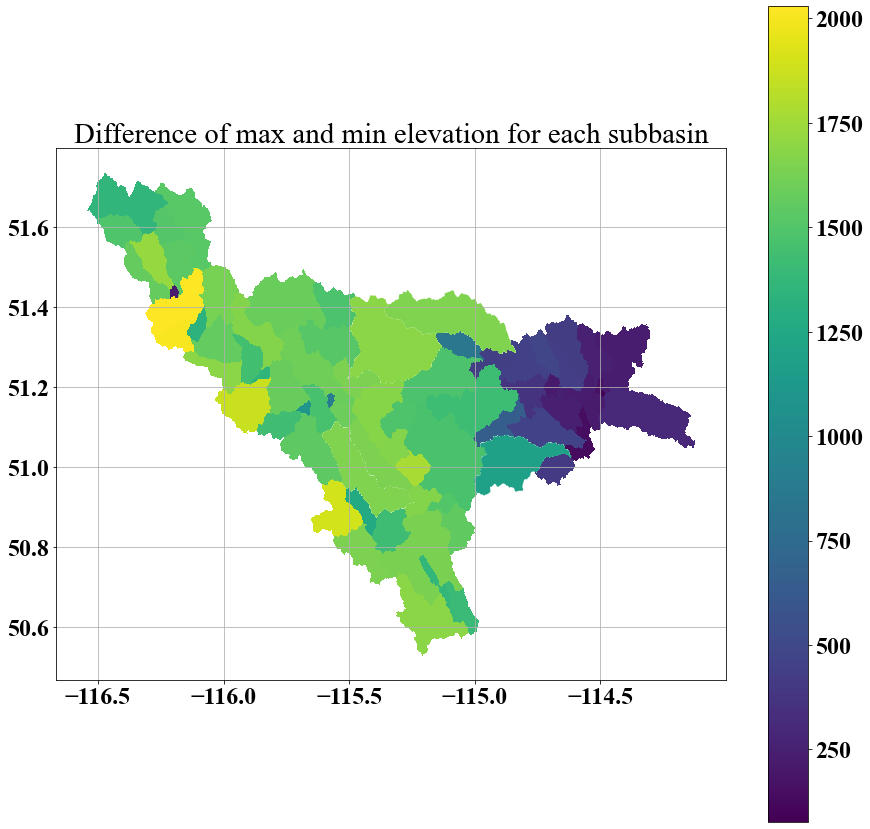

In [11]:
cat_elevetaion = cndx.zonal_stat(cndx.output_dir+cndx.case_name+'_subbasin.shp',
                                 '../data/MERIT_HYDRO/MERIT_dem.tif')
cat_elevetaion ['max_min'] = cat_elevetaion['max'] - cat_elevetaion ['min']
cat_elevetaion.to_file(cndx.temp_dir+cndx.case_name+'_subbasin_ele.shp')
#
f, axes = plt.subplots(1,1,figsize=(15,15))
cat_elevetaion.plot(column  = 'mean', legend=True, ax = axes)
plt.title ('Mean elevation for each subbasin')
plt.grid()
#
f, axes = plt.subplots(1,1,figsize=(15,15))
cat_elevetaion.plot(column  = 'std', legend=True, ax = axes)
plt.title ('Standard deviation for elevation for each subbasin')
plt.grid()
#
f, axes = plt.subplots(1,1,figsize=(15,15))
cat_elevetaion.plot(column  = 'max', legend=True, ax = axes)
plt.title ('Max elevation for each subbasin')
plt.grid()
#
f, axes = plt.subplots(1,1,figsize=(15,15))
cat_elevetaion.plot(column  = 'min', legend=True, ax = axes)
plt.title ('Min elevation for each subbasin')
plt.grid()
#
f, axes = plt.subplots(1,1,figsize=(15,15))
cat_elevetaion.plot(column  = 'max_min', legend=True, ax = axes)
plt.title ('Difference of max and min elevation for each subbasin')
plt.grid()


# Voronoi diagram for the centroid of subbasins

<ipython-input-9-d1644c304f38>:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['lat'] = shp.centroid.y
<ipython-input-9-d1644c304f38>:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['lon'] = shp.centroid.x
/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/candex/candex.py:1844: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  stations_buffert = stations.buffer(buffer) # add a buffer


no crs is provided for the point shapefiles; EASYMORE will allocate WGS84
epsg:4326


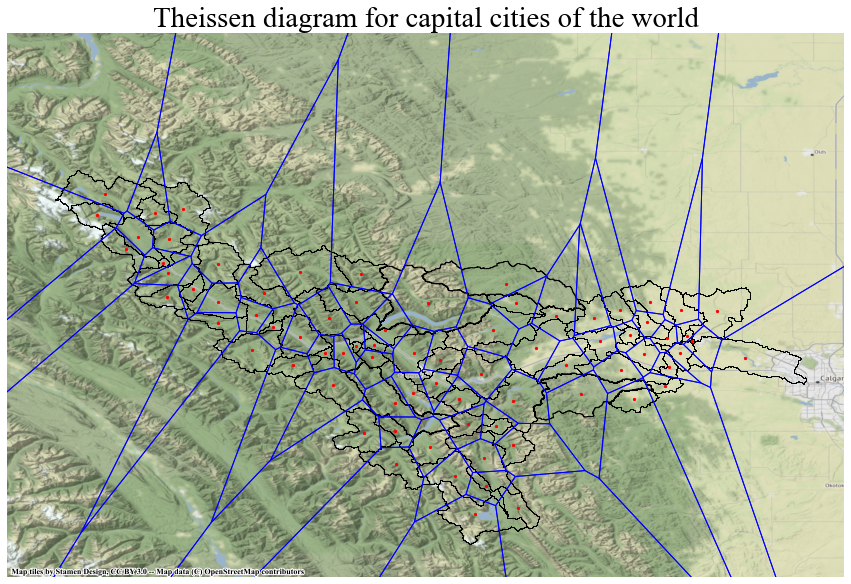

In [9]:
# loading candex
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
import pandas as pd
font = {'family' : 'Times New Roman',
         'weight' : 'bold',
         'size'   : 24}
matplotlib.rc('font', **font)

#
shp = gpd.read_file(cndx.output_dir+cndx.case_name+'_subbasin.shp')
df = pd.DataFrame()
df['lat'] = shp.centroid.y
df['lon'] = shp.centroid.x
shp_points = cndx.make_shape_point(df,
                                   'lon',
                                   'lat')
shp_points.to_file(cndx.temp_dir+cndx.case_name+'_subbasin_centroid.shp')
cndx.voronoi_diagram(cndx.temp_dir+cndx.case_name+'_subbasin_centroid.shp',
                     cndx.output_dir+cndx.case_name+'_subbasin_centroid_voronoi.shp')

# visualize
cat = gpd.read_file(cndx.output_dir+cndx.case_name+'_subbasin.shp')
voronoi = gpd.read_file(cndx.output_dir+cndx.case_name+'_subbasin_centroid_voronoi.shp')
centroid = gpd.read_file(cndx.temp_dir+cndx.case_name+'_subbasin_centroid.shp')
fig, ax = plt.subplots(figsize=(15, 10))
cat.plot(ax=ax, facecolor="none", edgecolor='black')
voronoi.plot(ax=ax, facecolor="none", edgecolor='blue')
centroid.plot(ax=ax, color='red', markersize = 5)
ax.axis('off')
plt.axis('equal')
ctx.add_basemap(ax, zoom=10, crs='EPSG:4326')
plt.title ('Theissen diagram for capital cities of the world')
plt.xlim(-116.7,-114)
plt.ylim(50.8,51.8)
# plt.savefig('../fig/Example3_A.png')
plt.show()



<ipython-input-18-14ad021c26ac>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cat_elevation['lat'] = cat_elevation.centroid.y
<ipython-input-18-14ad021c26ac>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cat_elevation['lon'] = cat_elevation.centroid.x


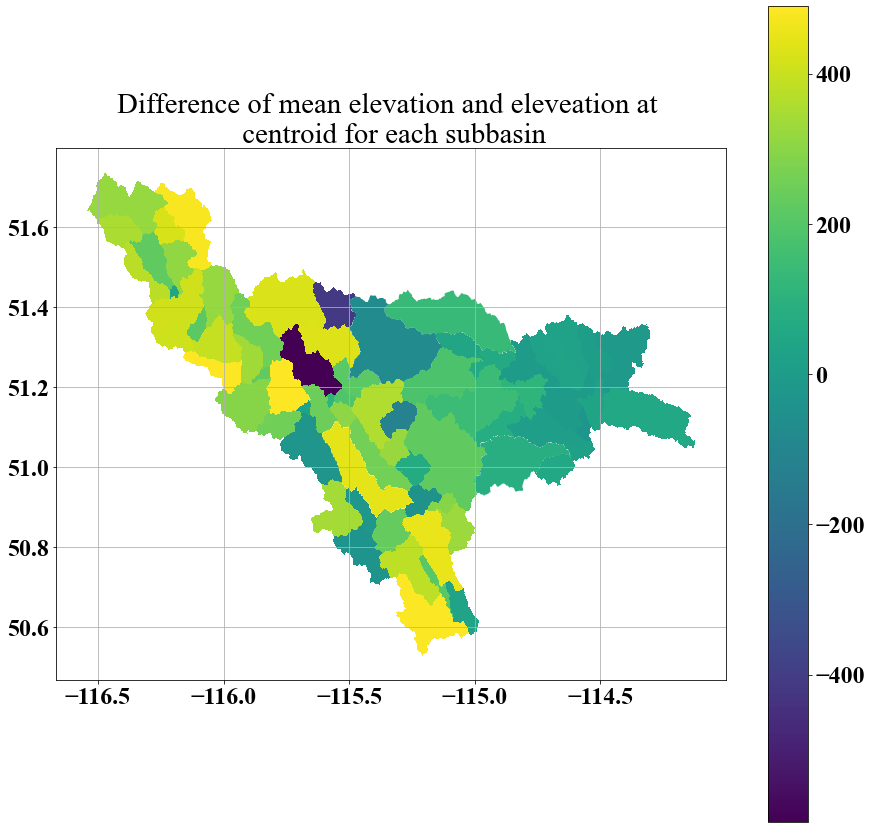

In [18]:
cat_elevation = gpd.read_file(cndx.temp_dir+cndx.case_name+'_subbasin_ele.shp')
cat_elevation['lat'] = cat_elevation.centroid.y
cat_elevation['lon'] = cat_elevation.centroid.x
cat_elevation['center'] = cndx.extract_value_tiff (cat_elevation['lon'],
                                                   cat_elevation['lat'],
                                                   '../data/MERIT_HYDRO/MERIT_dem.tif')
cat_elevation['diff_m_c'] = cat_elevation['mean'] - cat_elevation['center']
#
f, axes = plt.subplots(1,1,figsize=(15,15))
cat_elevation.plot(column  = 'diff_m_c', legend=True, ax = axes)
plt.title ('Difference of mean elevation and eleveation at \n centroid for each subbasin')
plt.grid()


In [ ]:
# create the elevation zones and convert it to vector (shapefile)

In [3]:
import numpy as np
slice_values = np.array([0,500,1000,1500,2000,2500,3000])
cndx.geotif_zones('../data/MERIT_HYDRO/MERIT_dem.tif',
                  cndx.temp_dir+cndx.case_name+'_MERIT_dem_zoned.tif',
                  slice_values = slice_values)
cndx.geotif2shp(cndx.temp_dir+cndx.case_name+'_MERIT_dem_zoned.tif',
                cndx.temp_dir+cndx.case_name+'_MERIT_dem_zoned.shp',
                name_of_filed = 'ele[m]',
                dissolve = True)

[   0.          500.         1000.         1500.         2000.
 2500.         3000.         3604.40014648]


# get the mean elevation for the subbasina and elevation zones

/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/candex/candex.py:1166: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_1['AS1']  = shp_1.area
/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/candex/candex.py:1178: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_2['AS2'] = shp_2.area
/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/candex/candex.py:1259: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  pairs = gpd.GeoDataFrame(nei, columns=['idx1','idx2'], crs=df1.crs)
/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/candex/candex.py:1263: FutureWarning: Assi

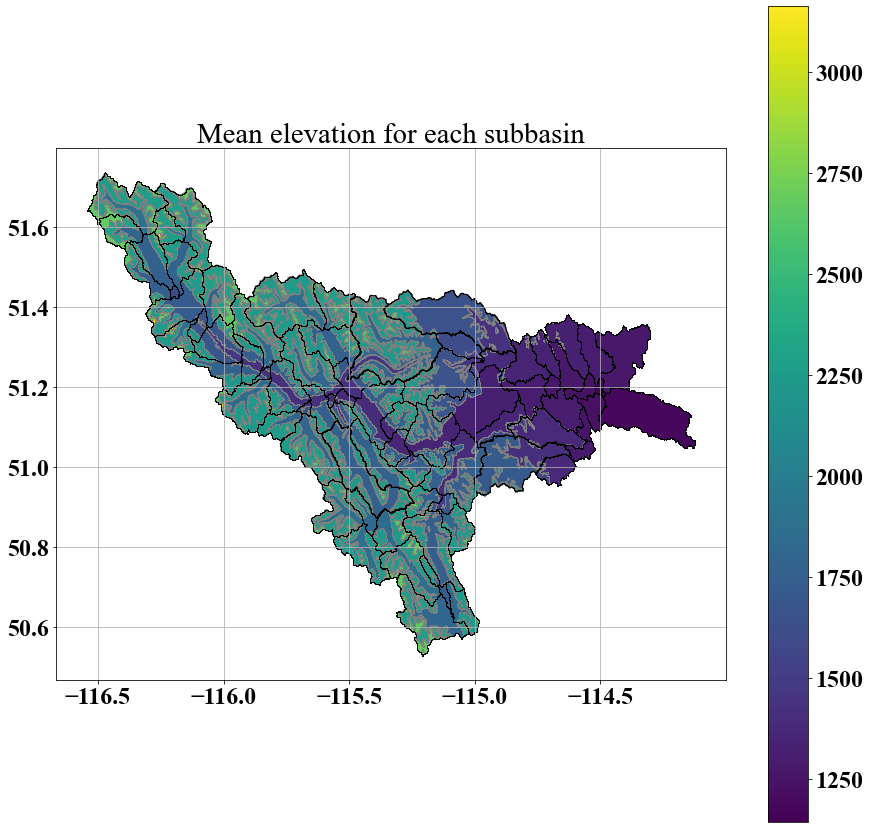

In [7]:
import geopandas as gpd
cat = gpd.read_file(cndx.output_dir+cndx.case_name+'_subbasin.shp')
elevation_zones = gpd.read_file(cndx.temp_dir+cndx.case_name+'_MERIT_dem_zoned.shp')

shp = cndx.intersection_shp (cat, elevation_zones)
shp.to_file(cndx.temp_dir+cndx.case_name+'_cat_MERIT_dem_zoned.shp')
cat_elevetaion = cndx.zonal_stat(cndx.temp_dir+cndx.case_name+'_cat_MERIT_dem_zoned.shp',
                                 '../data/MERIT_HYDRO/MERIT_dem.tif')
cat_elevetaion.to_file(cndx.temp_dir+cndx.case_name+'_cat_MERIT_dem_zoned_into.shp')
#
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
import pandas as pd
font = {'family' : 'Times New Roman',
         'weight' : 'bold',
         'size'   : 24}
matplotlib.rc('font', **font)
f, axes = plt.subplots(1,1,figsize=(15,15))
cat_elevetaion.plot(column  = 'mean', legend=True, ax = axes)
cat_elevetaion.plot(facecolor="none", ax = axes, edgecolor='grey')
cat.plot(facecolor="none", ax = axes, edgecolor='black')
plt.title ('Mean elevation for each elevation zone + subbasin')
plt.grid()


----------
----------
# Voronoi diagram for capital cities of the world

/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/candex/candex.py:1735: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  stations_buffert = stations.buffer(buffer) # add a buffer


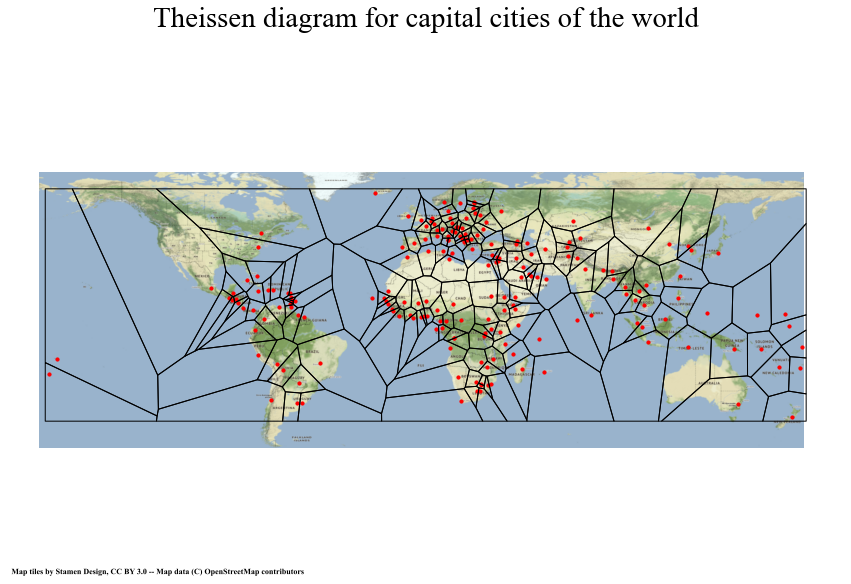

In [11]:
# loading candex
from candex.candex import candex
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
font = {'family' : 'Times New Roman',
         'weight' : 'bold',
         'size'   : 24}
matplotlib.rc('font', **font)

# initializing candex object and call voronoi function
cndx = candex()
cndx.voronoi_diagram('../data/target_shapefiles/Capitals_point.shp',
                      '../temporary/Capitals_point_voronio.shp')

# visualize
capitals = gpd.read_file('../data/target_shapefiles/Capitals_point.shp')
voronoi = gpd.read_file('../temporary/Capitals_point_voronio.shp')
fig, ax = plt.subplots(figsize=(15, 10))
capitals.plot(ax=ax, color='red', markersize = 10)
voronoi.plot(ax=ax, facecolor="none", edgecolor='black')
ax.axis('off')
plt.axis('equal')
ctx.add_basemap(ax, zoom=4, crs='EPSG:4326')
plt.title ('Theissen diagram for capital cities of the world')
# plt.savefig('../fig/Example3_A.png')
plt.show()


---------
---------
# Get the elevation of few cities in Provience of Alberta, Canada from the digital elevation model

In [10]:
# loading candex
from candex.candex import candex
# initializing candex object
cndx = candex()
import pandas as pd
d = {'ID': [1, 2, 3], 'city': ['Calgary', 'Banff', 'Canmore'],
     'lat': ['51.05', '51.18', '51.08'], 'lon': ['-114.07', '-115.56', '-115.36']}
df = pd.DataFrame(data=d)
shp_points = cndx.make_shape_point(df,
                                   'lon',
                                   'lat')
shp_points['elevation [m]'] = cndx.extract_value_tiff (shp_points['lon'],
                                                       shp_points['lat'],
                                                       '../data/MERIT_HYDRO/MERIT_dem.tif')
print(shp_points)


no crs is provided for the point shapefiles; EASYMORE will allocate WGS84
   ID     city    lat      lon                     geometry  elevation [m]
0   1  Calgary  51.05  -114.07  POINT (-114.07000 51.05000)    1062.599976
1   2    Banff  51.18  -115.56  POINT (-115.56000 51.18000)    1508.099976
2   3  Canmore  51.08  -115.36  POINT (-115.36000 51.08000)    1309.500000


----------
----------
# get the upstream areas

In [1]:
# loading candex
from candex.candex import candex
# initializing candex object
cndx = candex()
import geopandas as gpd

shp = gpd.read_file('/Users/shg096/Desktop/MERIT_Hydro/riv/riv_pfaf_71_MERIT_Hydro_v07_Basins_v01_bugfix1.shp')
upstreams = cndx.get_all_upstream(71028585,
                                  shp.COMID,
                                  shp.NextDownID)
shp = gpd.read_file('/Users/shg096/Desktop/MERIT_Hydro/cat_fixed/cat_pfaf_71_MERIT_Hydro_v07_Basins_v01_bugfix1_corr2.shp')
shp = shp.loc[shp['COMID'].isin(upstreams)]
shp.to_file('../data/target_shapefiles/Bow_MERIT_subbasins.shp')

